## Importing the libraries

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import dataframe_image as dfi

%matplotlib inline


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Saving the figures
PROJECT_ROOT_DIR = "."
PROJECT_NAME = "AirBnB-London-2020"
IMAGES_PATH = "../reports/figures/"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Reading in the data file

In [3]:
df_listings = pd.read_csv('../data/raw/listings.csv', dtype={'listing_url': 'object',
                                                      'price': 'object',
                                                      'weekly_price': 'object',
                                                      'monthly_price': 'object',
                                                      'security_deposit': 'object',
                                                      'cleaning_fee': 'object',
                                                      'extra_people': 'object',
                                                      'license': 'object', 
                                                      'jurisdiction_names': 'object',})

In [4]:
df_listings.shape

(86358, 106)

In [5]:
pd.set_option('display.max_columns', None)

# show listings data sample
df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20200414180850,2020-04-16,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,For art lovers I can give guest my Tate Member...,The flat only a 10 minute walk to Finsbury Par...,Guest will have access to the self catering ki...,I like to have little chats with my guest over...,I'm an artist and have my artwork up on the wa...,NaN,NaN,https://a0.muscache.com/im/pictures/ffb507b7-9...,NaN,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,71%,89%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,4.0,4.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",LB of Islington,Islington,NaN,Islington,Greater London,N4 3,London,"Islington, United Kingdom",GB,United Kingdom,51.56802,-0.11121,t,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",538.0,$65.00,$333.00,"$1,176.00",$100.00,$15.00,1,$15.00,1,29,1,1,29,29,1.0,29.0,12 months ago,t,27,57,84,359,2020-04-16,21,7,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,f,moderate,f,f,2,1,1,0,0.18
1,15400,https://www.airbnb.com/rooms/15400,20200414180850,2020-04-16,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,The building next door is in the process of be...,The underground stations are South Kensington ...,There are two wardrobes for guests exclusive u...,If I am in the country I like to welcome my gu...,NO SMOKING PLEASE.. No unauthorised guests. No...,NaN,NaN,https://a0.muscache.com/im/pictures/428392/462...,NaN,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",within a day,50%,67%,f,https://a0.musc

In [6]:
class format_data:
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def data_float(self):
        self = self.str.replace('$', '', regex=True).replace(',', '', regex=True).astype(float)
        
        return self
    
    def data_percentage(self):
        self = (self.str.replace('%', '', regex=True).astype('float')) / 100
        
        return self
    
    def dict_to_list(self):
        self = self.str.replace('{', '', regex=True).replace('}', '', regex=True).replace('\"', '', regex=True)
        self = self.str.split(',')
              
        return self

In [7]:
float_list = ['price','security_deposit','cleaning_fee','extra_people']
for x in float_list:
    df_listings[x] = format_data.data_float(df_listings[x])

In [8]:
float_list = ['host_response_rate','host_acceptance_rate']
for x in float_list:
    df_listings[x] = format_data.data_percentage(df_listings[x])

In [9]:
df_listings['amenities'] = format_data.dict_to_list(df_listings['amenities'])

## Data Exploration

In [10]:
df_listings.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,8.635800e+04,8.635800e+04,0.0,0.0,0.0,8.635800e+04,53473.000000,64813.000000,86348.000000,86348.000000,0.0,86358.000000,86358.000000,86358.000000,86226.000000,86216.000000,85416.000000,378.000000,86358.000000,56676.000000,64465.000000,86358.000000,86358.000000,86358.000000,8.635800e+04,86358.000000,86358.000000,8.635800e+04,8.635800e+04,86358.000000,8.635800e+04,86358.000000,86358.000000,86358.000000,86358.000000,86358.000000,86358.000000,63201.000000,63140.000000,63150.000000,63091.000000,63145.000000,63092.000000,63091.000000,86358.000000,86358.000000,86358.000000,86358.000000,64842.000000
mean,2.511516e+07,2.020041e+13,NaN,NaN,NaN,9.334733e+07,0.926660,0.830196,25.805450,25.805450,NaN,51.509916,-0.128245,3.211793,1.312122,1.415399,1.756580,643.611111,129.610725,191.465806,43.886109,1.610760,7.339644,4.474490,1.859559e+04,4.611142,5.812895,4.352354e+04,6.403469e+05,5.213305,6.099044e+05,7.870944,20.663239,33.379201,116.328898,17.531277,6.039417,92.491938,9.498464,9.256089,9.619375,9.642949,9.545346,9.253428,20.987448,17.973506,2.392390,0.052224,0.963183
std,1.238307e+07,1.269929e+01,NaN,NaN,NaN,9.543753e+07,0.183485,0.254690,134.219607,134.219607,NaN,0.046204,0.093286,2.033954,0.611861,0.920860,1.291133,849.684376,289.484146,322.896383,46.501627,1.368455,14.194697,19.151568,3.843374e+06,25.141390,29.128662,8.256667e+06,3.673454e+07,27.244416,3.496024e+07,10.379774,22.536341,35.047341,135.293902,37.393948,11.836707,10.357702,1.007258,1.156111,0.917570,0.913096,0.834854,1.057238,100.232081,98.678139,13.027134,0.712945,1.177591
min,1.391300e+04,2.020041e+13,NaN,NaN,NaN,4.775000e+03,0.000000,0.000000,0.000000,0.000000,NaN,51.294790,-0.510310,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.553035e+07,2.020041e+13,NaN,NaN,NaN,1.636343e+07,0.950000,0.760000,1.000000,1.000000,NaN,51.485850,-0.188380,2.000000,1.000000,1.000000,1.000000,130.000000,47.000000,0.000000,15.000000,1.000000,0.000000,1.000000,3.100000e+01,1.000000,1.000000,6.000000e+01,9.000000e+01,1.000000,8.500000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.200000
50%,2.573346e+07,2.020041e+13,NaN,NaN,NaN,5.013476e+07,1.000000,0.960000,1.000000,1.000000,NaN,51.514080,-0.126245,2.000000,1.000000,1.000000,1.000000,522.000000,83.000000,100.000000,30.000000,1.000000,0.000000,2.000000,1.125000e+03,2.000000,2.000000,1.125000e+03,1.125000e+03,2.000000,1.125000e+03,0.000000,8.000000,16.000000,63.000000,4.000000,1.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,1.000000,0.000000,0.560000
75%,3.654165e+07,2.020041e+13,NaN,NaN,NaN,1.522947e+08,1.000000,1.000000,5.000000,5.000000,NaN,51.537620,-0.069930,4.000000,1.

In [11]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86358 entries, 0 to 86357
Columns: 106 entries, id to reviews_per_month
dtypes: float64(28), int64(21), object(57)
memory usage: 69.8+ MB


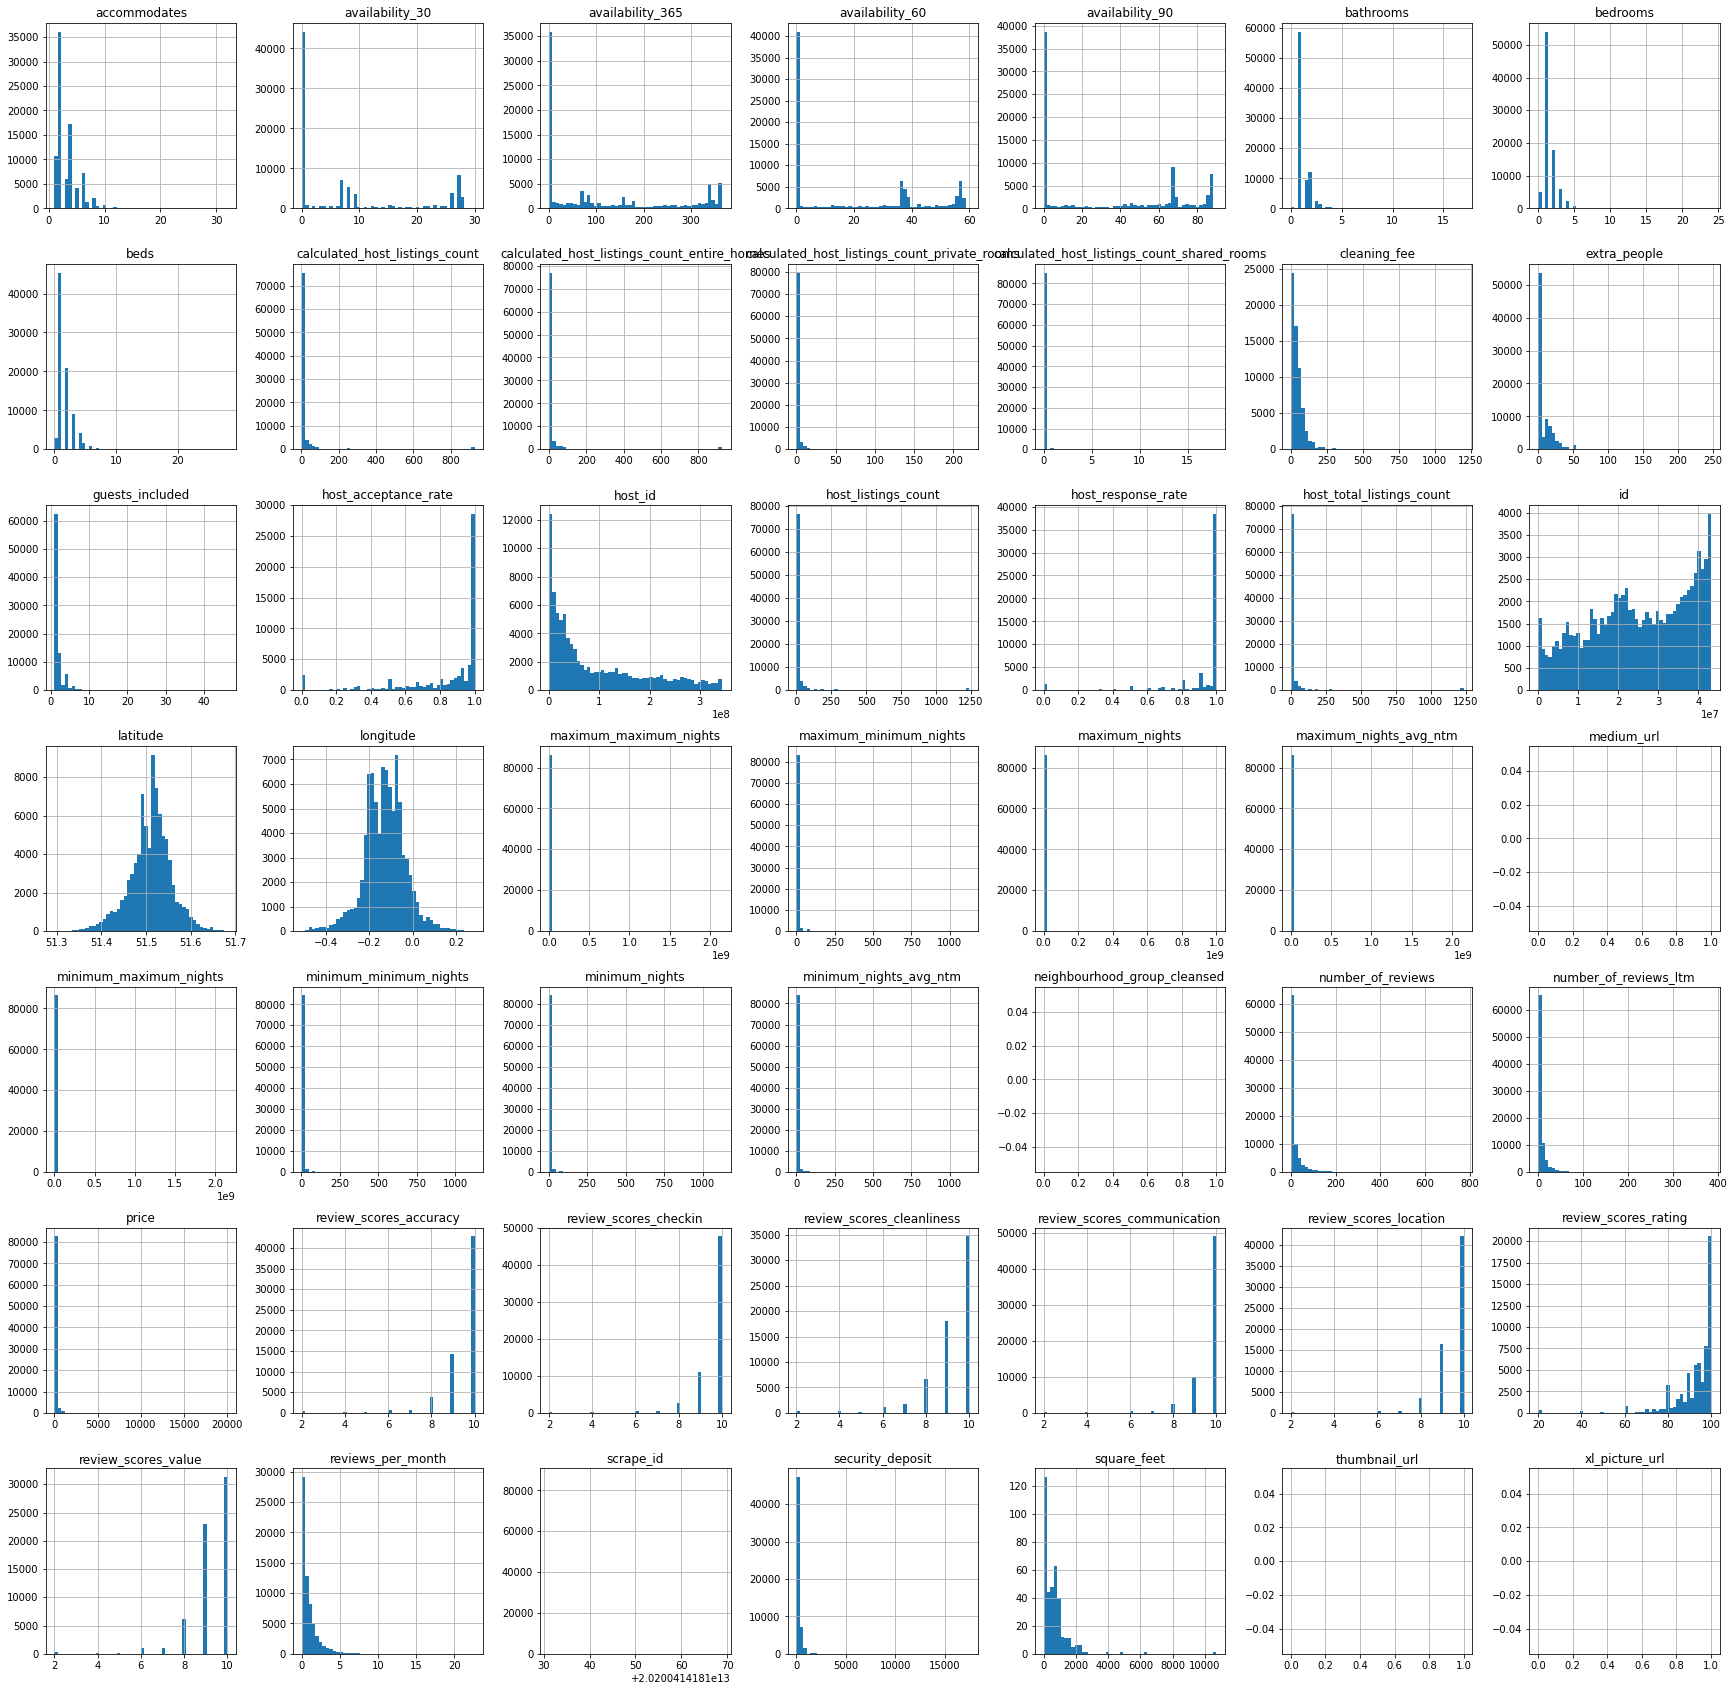

In [12]:
df_listings.hist(bins=50, figsize=(30,30))
plt.show()

In [13]:
#sns.pairplot(df_listings)

In [14]:
set(df_listings.columns[df_listings.isnull().mean()>0.75])

{'jurisdiction_names',
 'license',
 'medium_url',
 'monthly_price',
 'neighbourhood_group_cleansed',
 'square_feet',
 'thumbnail_url',
 'weekly_price',
 'xl_picture_url'}

### Removing Price Outliers

In [15]:
def find_outliers(df_listings):
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df_listings["price"], 25)
    
    #Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df_listings["price"],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    #print("Data points considered outliers for the feature '{}':".format("price"))
    filtered_data = df_listings[~((df_listings["price"] >= Q1 - step) & 
                                  (df_listings["price"] <= Q3 + step))].sort_values(by=["price"])
                                  
    #filtered_data["price"].hist()
    #outliers = filtered_data[filtered_data["price"] >= 1000.00]
    
    return filtered_data
                                  
                                  
outliers = find_outliers(df_listings).index
                                  
df_listings = df_listings.drop(df_listings.index[outliers]).reset_index(drop = True)

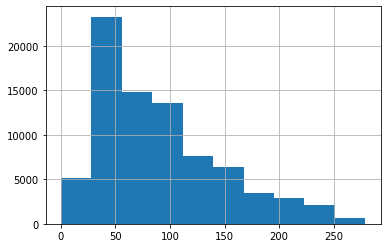

In [16]:
df_listings["price"].hist()

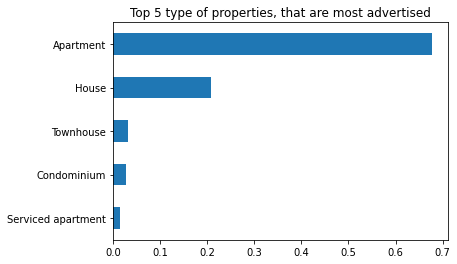

In [17]:
neighbourhood_vals = df_listings['property_type'].value_counts()

# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.

((neighbourhood_vals[0:5]/df_listings.shape[0]).sort_values()).plot(kind="barh");
plt.title("Top 5 type of properties, that are most advertised");

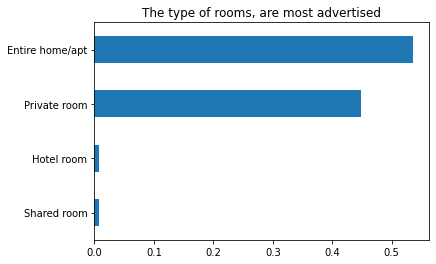

In [18]:
room_vals = df_listings['room_type'].value_counts()

# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.

((room_vals/df_listings.shape[0]).sort_values()).plot(kind="barh");
plt.title("The type of rooms, are most advertised");

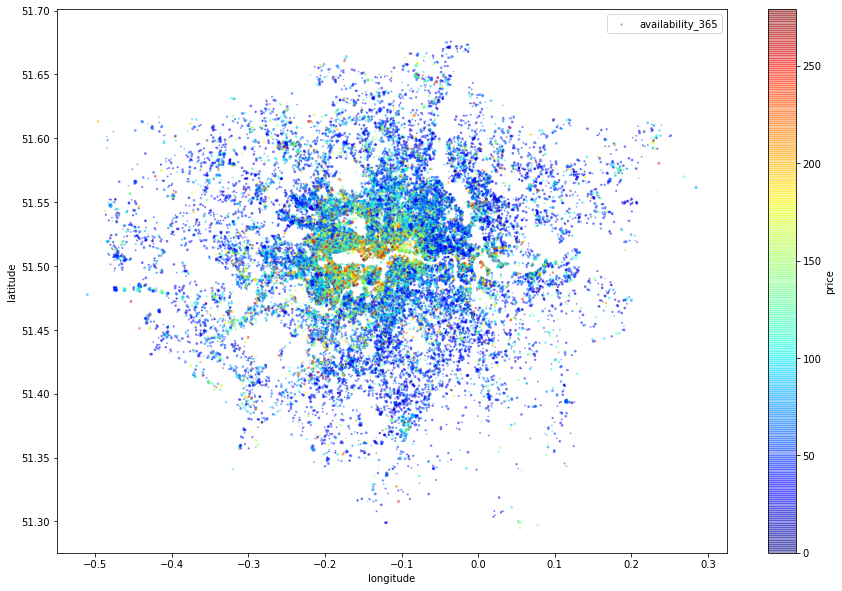

In [19]:
df_listings.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, figsize=(15,10),
                 s=(df_listings["availability_365"])/100, label="availability_365", 
                 c="price", cmap=plt.get_cmap('jet'), 
                 colorbar=True,
                 sharex=False)
plt.show()

Saving figure availability_365_prices_scatterplot


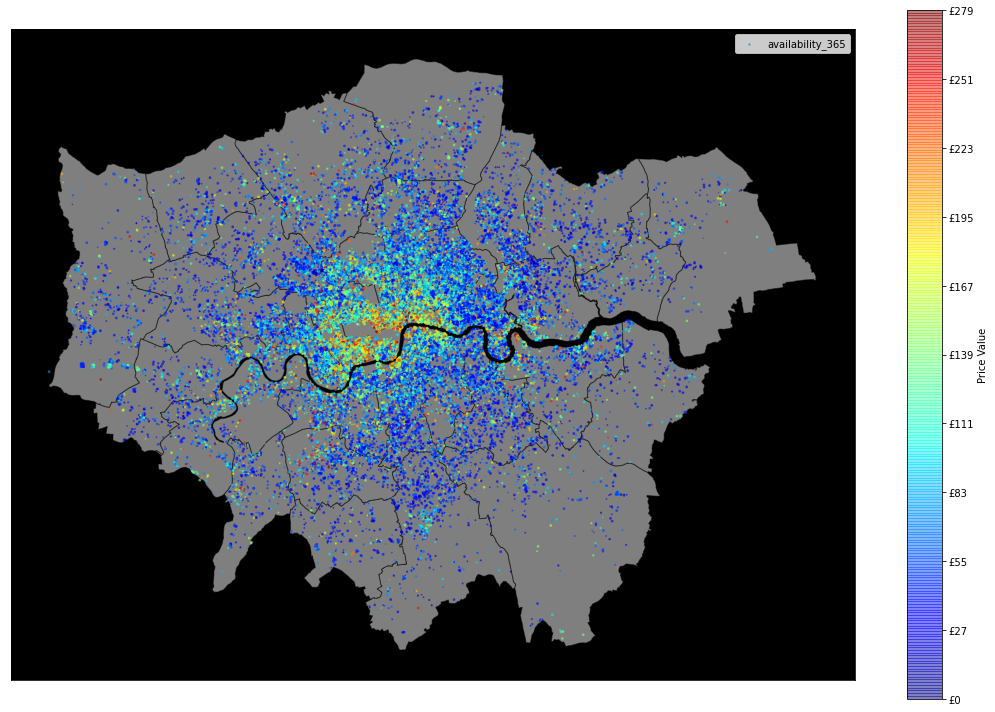

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

basemap = gpd.read_file('../data/external/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
basemap = basemap.to_crs(epsg=4326)


basemap = basemap.plot(alpha=0.5, edgecolor='k',color='White',figsize=(15,10),ax=ax)
basemap.set_facecolor('black')


x, y = df_listings['longitude'].values, df_listings['latitude'].values
basemap.scatter(x,y, alpha=0.5,
                 s=(df_listings["availability_365"])/100, label="availability_365", 
                 c=df_listings["price"], cmap=plt.get_cmap('jet'))


sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'))
prices = df_listings["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = fig.colorbar(sm, ticks=tick_values/prices.max(), alpha=0.5)
cbar.ax.set_yticklabels(["£%d"% v for v in tick_values], fontsize=10)
cbar.set_label('Price Value', fontsize=10)

# Removing ticks
plt.xticks([]),
plt.yticks([])

plt.legend(fontsize=10)
save_fig("availability_365_prices_scatterplot")
plt.show()

### What is the average price of the listings, for the different location within London?

In [21]:
price_df = df_listings[df_listings['price'].isnull() == False]

In [22]:
price_df['neighbourhood_cleansed'].value_counts()[:5]

Tower Hamlets             8062
Westminster               8039
Hackney                   6022
Camden                    5619
Kensington and Chelsea    4976
Name: neighbourhood_cleansed, dtype: int64

In [23]:
nb_price_avg = price_df.groupby('neighbourhood_cleansed', as_index=False).mean()
nb_price_avg = pd.DataFrame(nb_price_avg).sort_values(by='price', ascending=False)

In [24]:
nb_price_avg = nb_price_avg.rename(columns={'neighbourhood_cleansed':'Neighbourhood','price': 'Avg Price'})

In [25]:
def chart_plot(data, x_label, y_label):
    
    plt.figure(figsize=(10,5))

    sns.set(style="whitegrid")
    chart = sns.barplot(x=x_label, y=y_label, data=data)

    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=60, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='medium', 
        rotation_mode='anchor'
    )

Saving figure Neighbourhood_av_price_histogram_plots


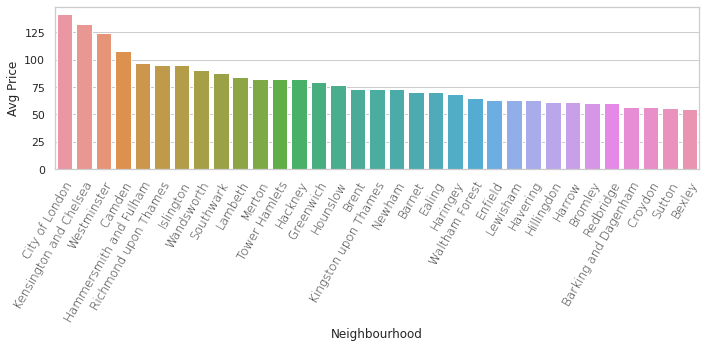

In [26]:
chart_plot(nb_price_avg,"Neighbourhood", "Avg Price")
save_fig("Neighbourhood_av_price_histogram_plots")

### What types of verifications are hosts using? How long did it take them to respond?

In [27]:
verifications_df = df_listings[df_listings['host_verifications'].isnull() == False]

In [28]:
verifications_df = verifications_df[verifications_df['host_verifications'] != '[]']

In [29]:
def verifications_types(column):
    verifications_dict = {}
    temp = []

    for i in column:
        temp.append(eval(i))
    
    for i in temp:
        try:
            for j in i:
                if j not in verifications_dict:
                    verifications_dict[j] = 1
                else:
                    verifications_dict[j] += 1
        except:
            continue
            
    return verifications_dict
        
verifications_types = verifications_types(verifications_df['host_verifications'])

In [30]:
for k,v in verifications_types.items():
    verifications_types[k] = round(v / verifications_df.shape[0] * 100, 3)

In [31]:
verifications_types = pd.DataFrame.from_dict(verifications_types,orient='index',columns=['A']).reset_index()
verifications_types = verifications_types.rename(columns={'index':'Verification Type','A': '% of listings'})
top10_verifications_types = verifications_types.sort_values(by='% of listings', ascending=False)[:10]

Saving figure Verification_type_price_histogram_plots


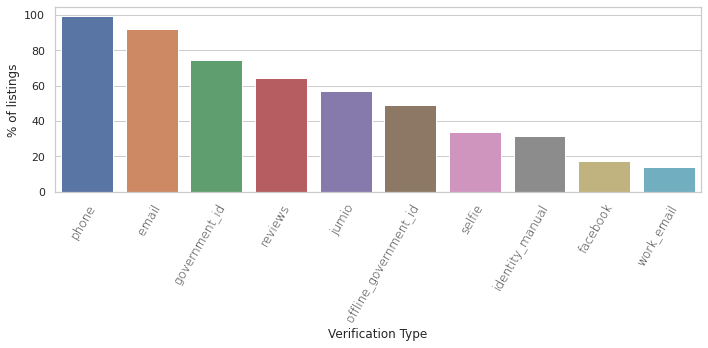

In [32]:
chart_plot(top10_verifications_types,"Verification Type", "% of listings")
save_fig("Verification_type_price_histogram_plots")

### What amenities are most used and does the count of amenities affect the review? 

In [33]:
df_left = df_listings[['id','amenities']]

In [34]:
df_right = df_listings[['id','review_scores_value']]

In [35]:
df_left.head()

,id,amenities
0,13913,"[TV, Cable TV, Wifi, Kitchen, Paid parking off..."
1,15400,"[TV, Cable TV, Internet, Wifi, Air conditionin..."
2,17506,"[TV, Internet, Wifi, Air conditioning, Breakfa..."
3,25023,"[TV, Wifi, Kitchen, Free parking on premises, ..."
4,25123,"[Wifi, Kitchen, Free street parking, Buzzer/wi..."


In [36]:
df_left = df_left.amenities.apply(pd.Series).merge(df_left, right_index = True, 
                                         left_index = True) \
                                  .drop(["amenities"], axis = 1) \
                                  .melt(id_vars = ['id'], value_name = "amenities") \
                                  .drop("variable", axis = 1) \
                                  .dropna()

In [37]:
result = pd.merge(df_left, df_right, on='id')

In [38]:
result = result.groupby('amenities').agg({'review_scores_value': ['count', 'min', 'max', 'mean']})

In [39]:
result = result.reset_index()

In [40]:
result.head().columns

MultiIndex([(          'amenities',      ''),
            ('review_scores_value', 'count'),
            ('review_scores_value',   'min'),
            ('review_scores_value',   'max'),
            ('review_scores_value',  'mean')],
           )

In [41]:
result = result.sort_values(by=[('review_scores_value', 'mean'),
                                ('review_scores_value',  'min'),
                                ('review_scores_value',  'max')], ascending=False)

In [42]:
result.columns = ["_".join(x) for x in result.columns.ravel()]

In [43]:
result.head().columns

Index(['amenities_', 'review_scores_value_count', 'review_scores_value_min',
       'review_scores_value_max', 'review_scores_value_mean'],
      dtype='object')

In [44]:
result.rename(columns={"amenities_":"Amenities", 
                       "review_scores_value_count":"Count Listings",
                       "review_scores_value_min":"Review Min Value",
                       "review_scores_value_max":"Review Max Value",
                       "review_scores_value_mean":"Review Avg Value"}, inplace=True)

In [45]:
result.head()

,Amenities,Count Listings,Review Min Value,Review Max Value,Review Avg Value
23,Beach view,1,10.0,10.0,10.0
62,Electric profiling bed,1,10.0,10.0,10.0
127,Mobile hoist,2,10.0,10.0,10.0
128,Mountain view,2,10.0,10.0,10.0
164,Shared gym,2,10.0,10.0,10.0


In [46]:
result = result[result['Count Listings'] > 10]

In [47]:
result = result.head(20).style.background_gradient() \
               .format({"Amenities": lambda x:x.lower()}) \
               .format({"Review Min Value": "{:20,.2f}"}) \
               .format({"Review Max Value": "{:20,.2f}"}) \
               .format({"Review Avg Value": "{:20,.2f}"}) \
               .hide_index()\
               .background_gradient(cmap='Blues')

In [48]:
result.set_properties(subset=["Amenities", 
                              "Count Listings", 
                              "Review Min Value", 
                              "Review Max Value", 
                              "Review Avg Value"], **{'text-align': 'left'}) \
      .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

Amenities,Count Listings,Review Min Value,Review Max Value,Review Avg Value
murphy bed,16,9.00,10.00,9.75
convection oven,79,9.00,10.00,9.75
outdoor seating,96,8.00,10.00,9.74
wine cooler,26,9.00,10.00,9.73
heated floors,89,7.00,10.00,9.73
sound system,102,9.00,10.00,9.71
formal dining area,53,8.00,10.00,9.70
printer,33,9.00,10.00,9.70
terrace,81,9.00,10.00,9.68
en suite bathroom,112,8.00,10.00,9.68


In [49]:
# dfi.export(result, '../reports/figures/top_amenities.png')

### What features assist in the pricing of a listing? 
- Could the price be predicted?
- importance of the features, rank features

### Preparing data

#### Removing rows with no target value

In [50]:
# Removing rows that do not have a price
# df = df_listings.dropna(subset=["price"])
df = df_listings[df_listings['price'] != 0]

#### Creating new features

In [51]:
# Creating the 'amenities - count' column
df.loc[:,"amenities - count"] = [len(i) for i in df["amenities"]]

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [52]:
# Creating the new column for 'amenities - count' column
df.loc[:,"Total Fees - With Deposit"] = df["security_deposit"] + df["cleaning_fee"]

In [53]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities - count,Total Fees - With Deposit
0,13913,https://www.airbnb.com/rooms/13913,20200414180850,2020-04-16,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,For art lovers I can give guest my Tate Member...,The flat only a 10 minute walk to Finsbury Par...,Guest will have access to the self catering ki...,I like to have little chats with my guest over...,I'm an artist and have my artwork up on the wa...,NaN,NaN,https://a0.muscache.com/im/pictures/ffb507b7-9...,NaN,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,0.71,0.89,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,4.0,4.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",LB of Islington,Islington,NaN,Islington,Greater London,N4 3,London,"Islington, United Kingdom",GB,United Kingdom,51.56802,-0.11121,t,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,"[TV, Cable TV, Wifi, Kitchen, Paid parking off...",538.0,65.0,$333.00,"$1,176.00",100.0,15.0,1,15.0,1,29,1,1,29,29,1.0,29.0,12 months ago,t,27,57,84,359,2020-04-16,21,7,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,f,moderate,f,f,2,1,1,0,0.18,44,115.0
1,15400,https://www.airbnb.com/rooms/15400,20200414180850,2020-04-16,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,The building next door is in the process of be...,The underground stations are South Kensington ...,There are two wardrobes for guests exclusive u...,If I am in the country I like to welcome my gu...,NO SMOKING PLEASE.. No unauthorised guests. No...,NaN,NaN,https://a0.muscache.com/im/pictures/428392/462...,NaN,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite

#### Removing Features

In [54]:
def drop_columns(df):
    
    # Dropping Columns that aren't needed
    regex_list = ['url','id','scraped','first_review','last_review','cancellation_policy', 'maximum', 
                  'minimum', 'host','requires']
    for i in regex_list:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
        
    df = df.drop(columns=['name','summary','space','description','neighborhood_overview','notes',
                          'transit','access','interaction','house_rules','latitude',
                          'longitude','street','neighbourhood','market','city','state',
                          'zipcode','smart_location','country_code','country','amenities', 
                          'is_location_exact','calendar_updated'])
    
    # remove columns with 70% or high with missing data
    col_nulls = set(df.columns[df.isnull().mean()>0.70])
    df = df.drop(list(col_nulls), axis=1)
    
    return df

df = drop_columns(df)

In [55]:
# Renaming property types to other where their total count is less than 30
counts = df['property_type'].value_counts()

df['property_type'] = np.where(df['property_type'].isin(counts.index[counts >= 30]), df['property_type'], 'Other')

#### Train / Test split

In [56]:
# Extract features and labels
X = df.drop("price", axis=1) # drop labels for training set
y = df["price"].copy()

# List of features for later use
X_columns = list(X.columns)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [58]:
X_train_num = X_train.select_dtypes(include=['float', 'int'])
X_train_cat = X_train.select_dtypes(include=['object'])

In [59]:
X_train_num.head()

,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,amenities - count,Total Fees - With Deposit
30413,1,1.0,1.0,0.0,0.0,30.0,1,10.0,0,0,0,0,3,0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.1,9,30.0
41645,2,1.0,1.0,1.0,0.0,15.0,1,0.0,7,37,52,52,26,11,99.0,10.0,10.0,10.0,10.0,9.0,10.0,1.2,30,15.0
16230,2,1.0,1.0,1.0,NaN,NaN,1,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,NaN
55732,6,1.5,4.0,4.0,0.0,0.0,1,0.0,0,9,9,49,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,0.0
74351,2,1.5,0.0,1.0,NaN,NaN,1,0.0,8,38,68,68,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN


In [60]:
X_train_cat.head()

,experiences_offered,neighbourhood_cleansed,property_type,room_type,bed_type,has_availability,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification
30413,none,Islington,Apartment,Private room,Real Bed,t,f,f,f,f
41645,none,Southwark,Apartment,Entire home/apt,Real Bed,t,f,f,f,f
16230,none,Islington,Apartment,Private room,Pull-out Sofa,t,f,f,f,f
55732,none,Richmond upon Thames,Apartment,Entire home/apt,Real Bed,t,t,f,f,f
74351,none,Hounslow,House,Private room,Real Bed,t,t,f,f,f


#### Data selector 

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

#### Creating the Pipeline

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

num_attribs = list(X_train_num.columns)
cat_attribs = list(X_train_cat.columns)

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])



In [63]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('pwr_transformer', PowerTransformer()),
    ])

In [64]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [65]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

Feature 0: 0.298466
Feature 1: 0.059246
Feature 2: 0.183897
Feature 3: 0.168747
Feature 4: 0.109085
Feature 5: 0.255911
Feature 6: 0.097504
Feature 7: 0.038208
Feature 8: 0.052319
Feature 9: 0.051945
Feature 10: 0.057135
Feature 11: 0.063192
Feature 12: 0.022038
Feature 13: 0.021246
Feature 14: 0.007560
Feature 15: 0.005464
Feature 16: 0.007332
Feature 17: 0.003158
Feature 18: 0.008762
Feature 19: 0.010688
Feature 20: 0.011182
Feature 21: 0.023041
Feature 22: 0.046630
Feature 23: 0.217005
Feature 24: 0.000000
Feature 25: 0.003448
Feature 26: 0.000000
Feature 27: 0.007640
Feature 28: 0.000000
Feature 29: 0.000000
Feature 30: 0.000198
Feature 31: 0.002813
Feature 32: 0.003495
Feature 33: 0.002222
Feature 34: 0.010243
Feature 35: 0.000565
Feature 36: 0.004135
Feature 37: 0.008235
Feature 38: 0.002677
Feature 39: 0.000000
Feature 40: 0.001589
Feature 41: 0.004282
Feature 42: 0.003475
Feature 43: 0.003019
Feature 44: 0.000543
Feature 45: 0.005428
Feature 46: 0.002249
Feature 47: 0.002865
Fe

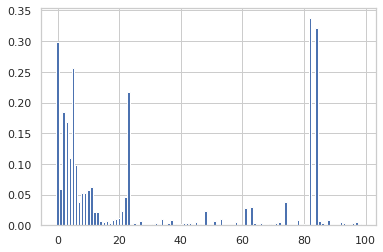

In [94]:
# example of mutual information feature selection for numerical input data
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
 
# feature selection
def select_features(X_train, y_train, X_test, k='all'):
    # configure to select all features
    fs = SelectKBest(score_func=mutual_info_regression, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_prepared, y_train, X_test_prepared)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

## Building the Model

### Base Evaluation - Fittng the training data with various models

In [67]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

def base_models(model, X_train_prepared, X_test_prepared, y_train, y_test):
    
    model.fit(X_train_prepared, y_train)
    
    model_predict = model.predict(X_test_prepared)
    mse = mean_squared_error(y_test, model_predict)
    rmse = np.sqrt(mse)
    
    return rmse

In [68]:
# Ridge Regression - Base Model
ridge = Ridge(alpha=0.4, normalize=True)
base_models(ridge, X_train_prepared, X_test_prepared, y_train, y_test)

35.65340000476921

In [69]:
# Decision Tree Regression - Base Model
tree_reg = DecisionTreeRegressor(random_state=42)
base_models(tree_reg, X_train_prepared, X_test_prepared, y_train, y_test)

46.8758245872653

In [70]:
# Random Forest Regression - Base Model
forest_reg = RandomForestRegressor(random_state=42)
base_models(forest_reg, X_train_prepared, X_test_prepared, y_train, y_test)

33.023494037315274

### Fine tune the model with cross-validation

In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def display_scores(model, X_train_prepared, y_train):
    
    cv = KFold(n_splits=10, random_state=42, shuffle=True)
    
    scores = cross_val_score(model, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)
    
    print("Scores:", rmse_scores)
    print("Mean:", rmse_scores.mean())
    print("Standard deviation:", rmse_scores.std())

In [72]:
# Ridge Regression - CV Model
display_scores(ridge, X_train_prepared, y_train)

Scores: [35.71063892 35.45738031 34.89764461 35.85075674 35.84874173 34.50860106
 35.436301   36.10872072 35.87600608 35.6112325 ]
Mean: 35.53060236524622
Standard deviation: 0.4642765161072267


In [73]:
# Decision Tree Regression - CV Model
display_scores(tree_reg, X_train_prepared, y_train)

Scores: [45.56739657 45.71194668 44.73625042 46.23011413 46.30616474 45.99356205
 46.41851883 46.36033727 46.63289633 45.32900825]
Mean: 45.9286195281134
Standard deviation: 0.558457805566797


In [74]:
# Random Forest Regression - CV Model
display_scores(forest_reg, X_train_prepared, y_train)

Scores: [32.5908612  32.40070882 31.37515732 32.76654867 33.31515899 32.12943847
 32.95509585 33.24912758 33.18629848 32.74045876]
Mean: 32.670885414450616
Standard deviation: 0.5622584734011974


### Feature Selection Top 15

In [81]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_prepared, y_train, X_test_prepared, 30)

In [82]:
# Ridge Regression with feature selection - CV Model
display_scores(ridge, X_train_fs, y_train)

Scores: [36.97763855 36.62087958 35.91166399 36.83890078 36.88371214 35.62717273
 36.37824518 37.28320204 36.92989283 36.49377958]
Mean: 36.59450874016493
Standard deviation: 0.4833800885674435


In [79]:
# Random Forest Regression with feature selection - CV Model
display_scores(forest_reg, X_train_fs, y_train)

Scores: [36.08658035 35.40158156 35.05646837 35.41946133 35.90684951 35.10442317
 35.8135261  36.17576047 36.5363311  36.07008876]
Mean: 35.75710707306189
Standard deviation: 0.466033340509843


### Finding best Train / Test scores

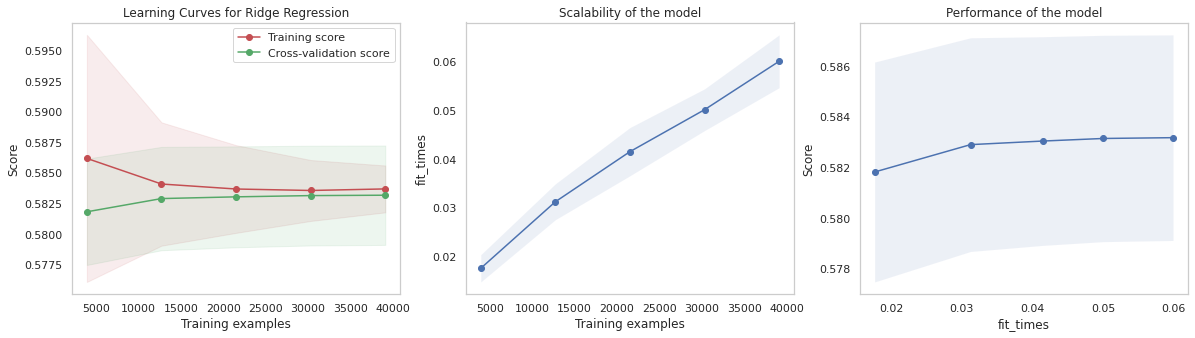

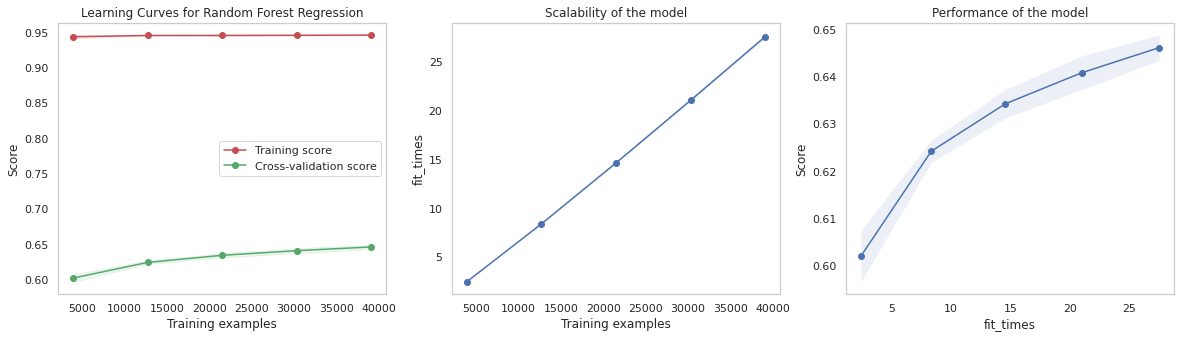

In [83]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


# fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = r"Learning Curves for Ridge Regression"
# Ridge Regression:
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=0)
estimator = Ridge(alpha=0.4, normalize=True)
plot_learning_curve(estimator, title, X_train_fs, y_train, cv=cv, n_jobs=4)


title = r"Learning Curves for Random Forest Regression"
# Random Forest Regression:
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X_train_fs, y_train,cv=cv, n_jobs=4)

plt.show()

### Fine tunning model

In [86]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [500], 'max_depth': [20]}
  ]

forest_reg2 = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg2, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           n_jobs=-1)

grid_search.fit(X_train_fs, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_depth': [20], 'n_estimators': [500]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [87]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=20, n_estimators=500, random_state=42)

In [89]:
y_pred = grid_search.predict(X_test_fs)

In [90]:
mse = mean_squared_error(y_test,y_pred)

In [91]:
rmse = np.sqrt(mse)

In [92]:
rmse

33.28653876432628